In [2]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib as mpl

# 2 Years of Quant-USD Financial Data

In [3]:
initial_data = yf.download("QNT-USD", start="2020-11-01", end="2022-11-01")

[*********************100%***********************]  1 of 1 completed


In [4]:

initial_data.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-11-01,13.859604,14.418903,13.065248,13.756181,13.756181,3149086
2020-11-02,13.756182,13.917675,12.923141,13.046440,13.046440,3938612
2020-11-03,13.046420,13.113887,12.332922,13.071543,13.071543,8284875
2020-11-04,13.071731,13.359848,12.432226,13.336169,13.336169,9531315
2020-11-05,13.336154,13.541724,12.792889,13.250077,13.250077,5131883


In [5]:
initial_data['Adj Close'].head()

Date
2020-11-01    13.756181
2020-11-02    13.046440
2020-11-03    13.071543
2020-11-04    13.336169
2020-11-05    13.250077
Name: Adj Close, dtype: float64

In [6]:
data =  initial_data['Adj Close']
data.info()


<class 'pandas.core.series.Series'>
DatetimeIndex: 730 entries, 2020-11-01 to 2022-10-31
Series name: Adj Close
Non-Null Count  Dtype  
--------------  -----  
730 non-null    float64
dtypes: float64(1)
memory usage: 11.4 KB


# Price Movement of Quant-USD Over 2 Years

array([<AxesSubplot:xlabel='Date'>], dtype=object)

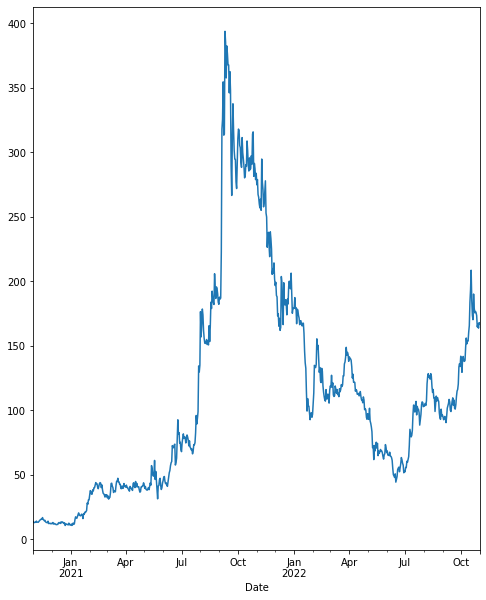

In [9]:
data.plot(figsize=(8, 10), subplots=True)

# Annualized Volatility Calculation

In [8]:

data.head()

Date
2020-11-01    13.756181
2020-11-02    13.046440
2020-11-03    13.071543
2020-11-04    13.336169
2020-11-05    13.250077
Name: Adj Close, dtype: float64

In [9]:

data.tail()

Date
2022-10-27    164.615906
2022-10-28    166.767014
2022-10-29    163.638809
2022-10-30    167.922531
2022-10-31    166.857559
Name: Adj Close, dtype: float64

In [28]:
df=data[-180:-1]
df.head()

Date
2022-05-05    91.836853
2022-05-06    89.984909
2022-05-07    87.258179
2022-05-08    83.391319
2022-05-09    71.093048
Name: Adj Close, dtype: float64

In [29]:
log_return = np.log(df/ df.shift(1))
log_return

Date
2022-05-05         NaN
2022-05-06   -0.020372
2022-05-07   -0.030771
2022-05-08   -0.045327
2022-05-09   -0.159555
                ...   
2022-10-26   -0.013035
2022-10-27   -0.052046
2022-10-28    0.012983
2022-10-29   -0.018936
2022-10-30    0.025841
Name: Adj Close, Length: 179, dtype: float64

In [30]:
vol = np.sqrt(365) * log_return.std()
print('The annualised volatility is', round(vol*100,2), '%')


The annualised volatility is 107.47 %


In [31]:
df[-1]

167.9225311279297

# Binomial Tree Model

In [33]:
S0 = df[-1]              # spot stock price
K = 160                 # strike
T = 0.5                 # maturity 
r = 0.035                 # risk free rate 
sig = 0.2               # diffusion coefficient or volatility
N = 2                  # number of periods or number of time steps  
payoff = "put"          # payoff 

In [34]:
sig

0.2

In [35]:
dT = float(T) / N                             # Delta t
u = np.exp(sig * np.sqrt(dT))                 # up factor
d = 1.0 / u        

In [36]:
S = np.zeros((N + 1, N + 1))
S[0, 0] = S0
z = 1
for t in range(1, N + 1):
    for i in range(z):
        S[i, t] = S[i, t-1] * u
        S[i+1, t] = S[i, t-1] * d
    z += 1

In [37]:
S

array([[167.92253113, 185.58309789, 205.10104268],
       [  0.        , 151.9425895 , 167.92253113],
       [  0.        ,   0.        , 137.48334037]])

In [38]:
a = np.exp(r * dT)    # risk free compound return
p = (a - d)/ (u - d)  # risk neutral up probability
q = 1.0 - p           # risk neutral down probability
p

0.518889627005782

# Option Value Calculation

In [39]:
S_T = S[:,-1]
V = np.zeros((N + 1, N + 1))
if payoff =="call":
    V[:,-1] = np.maximum(S_T-K, 0.0)
elif payoff =="put":
    V[:,-1] = np.maximum(K-S_T, 0.0)
V

array([[ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        , 22.51665963]])

# European Put Option Value

In [40]:
# for European Option
for j in range(N-1, -1, -1):
    for i in range(j+1):
        V[i,j] = np.exp(-r*dT) * (p * V[i,j + 1] + q * V[i + 1,j + 1])
V

array([[ 5.1214537 ,  0.        ,  0.        ],
       [ 0.        , 10.73862327,  0.        ],
       [ 0.        ,  0.        , 22.51665963]])

In [41]:
print('European ' + payoff, str( V[0,0]))

European put 5.121453698482644


# Monte-Carlo Simulation

In [42]:
def mcs_simulation_np(p):
    M = p
    I = p
    dt = T / M 
    S = np.zeros((M + 1, I))
    S[0] = S0 
    rn = np.random.standard_normal(S.shape) 
    for t in range(1, M + 1): 
        S[t] = S[t-1] * np.exp((r - sigma ** 2 / 2) * dt + sigma * np.sqrt(dt) * rn[t]) 
    return S

In [43]:
T = 0.5
r = 0.035
sigma = 0.2
S0 = 167.92
K = 160

In [44]:
S = mcs_simulation_np(1000)

In [45]:
S = np.transpose(S)
S

array([[167.92      , 168.53957823, 168.52392315, ..., 197.69277712,
        195.91920193, 196.92266059],
       [167.92      , 168.07463743, 168.67838622, ..., 168.16212297,
        168.2116277 , 168.47136783],
       [167.92      , 167.73576778, 169.06503192, ..., 209.63611994,
        208.240893  , 209.42824464],
       ...,
       [167.92      , 167.30019235, 166.82975203, ..., 169.38606023,
        168.66938544, 169.62851094],
       [167.92      , 168.39134135, 168.53602246, ..., 171.21595653,
        172.59181848, 171.8244983 ],
       [167.92      , 168.07883166, 167.69585037, ..., 149.14868642,
        148.47873189, 147.9884638 ]])

Text(0.5, 1.0, 'Frequency distribution of the simulated end-of-preiod values')

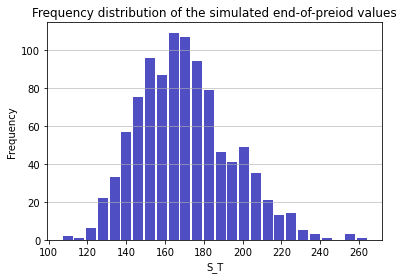

In [46]:
import matplotlib.pyplot as plt
n, bins, patches = plt.hist(x=S[:,-1], bins='auto', color='#0504aa',alpha=0.7, rwidth=0.85)

plt.grid(axis='y', alpha=0.75)
plt.xlabel('S_T')
plt.ylabel('Frequency')
plt.title('Frequency distribution of the simulated end-of-preiod values')

In [47]:
p = np.mean(np.maximum(K - S[:,-1],0))
print('European put', str(p))

European put 4.945738476651169


# Option Value

In [48]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as si

In [49]:
def euro_option_bsm(S, K, T, r, q, vol, payoff):
    
    #S: spot price
    #K: strike price
    #T: time to maturity
    #r: risk free rate
    #q: continuous dividend yield
    #vol: volatility of underlying asset
    #payoff: call or put
    
    d1 = (np.log(S / K) + (r - q + 0.5 * vol ** 2) * T) / (vol * np.sqrt(T))
    d2 = (np.log(S / K) + (r - q - 0.5 * vol ** 2) * T) / (vol * np.sqrt(T))
    if payoff == "call":
        option_value = S * np.exp(-q * T) * si.norm.cdf(d1, 0.0, 1.0) - K * np.exp(-r * T) * si.norm.cdf(d2, 0.0, 1.0)
    elif payoff == "put":
        option_value =  - S * np.exp(-q * T) * si.norm.cdf(-d1, 0.0, 1.0) + K * np.exp(-r * T) * si.norm.cdf(-d2, 0.0, 1.0)
    
    return option_value

In [82]:
euro_option_bsm(167.92, 160, 0.5, 0.035, 0, 0.2, 'put')

4.789496694066443

# Figure for Stock Price / Option Price

In [88]:
S = np.linspace(100,200,11)
Put = np.zeros((len(S),1))
for i in range(len(S)):
    Put [i] = euro_option_bsm(S[i], 160, 0.5, 0.035, 0, 0.2, 'put')

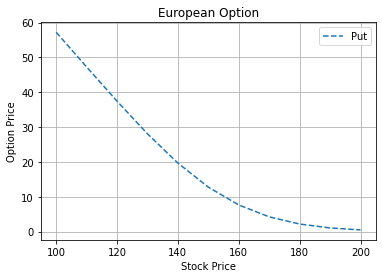

In [90]:
fig = plt.figure()
plt.plot(S, Put, '--')
plt.grid()
plt.xlabel('Stock Price')
plt.ylabel('Option Price')
plt.title('European Option')
plt.legend(['Put'])

# Delta Calculation

In [54]:
def delta(S, K, T, r, q, vol, payoff):
    
    d1 = (np.log(S / K) + (r - q + 0.5 * vol ** 2) * T) / (vol * np.sqrt(T))
    if payoff == "call":
        delta = np.exp(-q * T) * si.norm.cdf(d1, 0.0, 1.0)
    elif payoff == "put":
        delta =  - np.exp(-q * T) * si.norm.cdf(-d1, 0.0, 1.0)
    
    return delta

In [91]:
delta(167.92, 160, 0.5, 0.035, 0, 0.2, 'put')

-0.29594992149754884

In [93]:
S = np.linspace(100,200,11)
Delta_Put = np.zeros((len(S),1))
for i in range(len(S)):

    Delta_Put [i] = delta(S[i], 160, 0.5, 0.035, 0, 0.2, 'put')

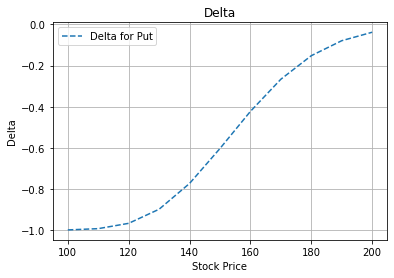

In [95]:
fig = plt.figure()
plt.plot(S, Delta_Put, '--')
plt.grid()
plt.xlabel('Stock Price')
plt.ylabel('Delta')
plt.title('Delta')
plt.legend(['Delta for Put'])

# Gamma Calculation

In [59]:
def gamma(S, K, T, r, q, vol, payoff):
    
    d1 = (np.log(S / K) + (r - q + 0.5 * vol ** 2) * T) / (vol * np.sqrt(T))
    gamma = np.exp(- q * T) * si.norm.pdf(d1, 0.0, 1.0) / (vol * S * np.sqrt(T))
    
    return gamma

In [96]:
gamma(167.92, 160, 0.5, 0.035, 0, 0.2, 'put')

0.01455081546455334

In [99]:
S = np.linspace(100,200,11)
Gamma = np.zeros((len(S),1))
for i in range(len(S)):
    Gamma [i] = gamma(S[i],160, 0.5, 0.035, 0, 0.2, 'put')

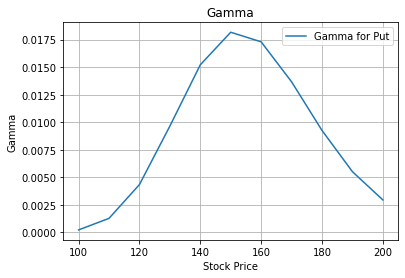

In [100]:
fig = plt.figure()
plt.plot(S, Gamma, '-')
plt.grid()
plt.xlabel('Stock Price')
plt.ylabel('Gamma')
plt.title('Gamma')
plt.legend(['Gamma for Put'])

# Speed Calculation

In [64]:
def speed(S, K, T, r, q, vol, payoff):
    
    d1 = (np.log(S / K) + (r - q + 0.5 * vol ** 2) * T) / (vol * np.sqrt(T))
    speed = - np.exp(-q * T) * si.norm.pdf(d1, 0.0, 1.0) / ((vol **2) * (S**2) * np.sqrt(T)) * (d1 + vol * np.sqrt(T))
    
    return speed

In [101]:
speed(167.92, 160, 0.5, 0.035, 0, 0.2, 'put')

-0.0002935406501924355

In [102]:
S = np.linspace(100,200,11)
Speed = np.zeros((len(S),1))
for i in range(len(S)):
    Speed [i] = speed(S[i], 160, 0.5, 0.035, 0, 0.2, 'put')

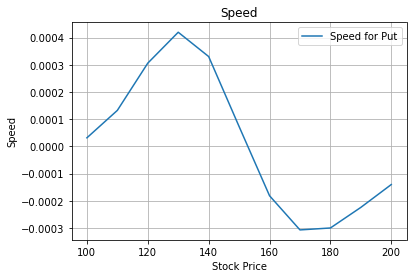

In [103]:
fig = plt.figure()
plt.plot(S, Speed, '-')
plt.grid()
plt.xlabel('Stock Price')
plt.ylabel('Speed')
plt.title('Speed')
plt.legend(['Speed for Put'])

# Theta Calculation

In [69]:
def theta(S, K, T, r, q, vol, payoff):
    
    d1 = (np.log(S / K) + (r - q + 0.5 * vol ** 2) * T) / (vol * np.sqrt(T))
    d2 = (np.log(S / K) + (r - q - 0.5 * vol ** 2) * T) / (vol * np.sqrt(T))
    if payoff == "call":
        theta = vol * S * np.exp(-q * T) * si.norm.pdf(d1, 0.0, 1.0) / (2 * np.sqrt(T)) - q * S * np.exp(-q * T) * si.norm.cdf(d1, 0.0, 1.0) + r * K * np.exp(-r * T) * si.norm.cdf(d2, 0.0, 1.0)
    elif payoff == "put":
        theta = vol * S * np.exp(-q * T) * si.norm.pdf(-d1, 0.0, 1.0) / (2 * np.sqrt(T)) + q * S * np.exp(-q * T) * si.norm.cdf(-d1, 0.0, 1.0) - r * K * np.exp(-r * T) * si.norm.cdf(-d2, 0.0, 1.0)
    
    return theta

In [104]:
theta(167.92, 160, 0.5, 0.035, 0, 0.2, 'put')

6.298834394623983

In [111]:
T = np.linspace(0.25,3,12)
Theta_Call = np.zeros((len(T),1))
Theta_Put = np.zeros((len(T),1))
for i in range(len(T)):
    Theta_Put [i] = theta(167.92, 160, T[i], 0.035, 0, 0.2, 'put')

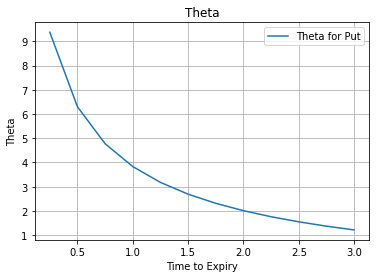

In [112]:
fig = plt.figure()
plt.plot(T, Theta_Put, '-')
plt.grid()
plt.xlabel('Time to Expiry')
plt.ylabel('Theta')
plt.title('Theta')
plt.legend(['Theta for Put'])

# Rho Calculation

In [74]:
def rho(S, K, T, r, q, vol, payoff):
    
    d1 = (np.log(S / K) + (r - q + 0.5 * vol ** 2) * T) / (vol * np.sqrt(T))
    d2 = (np.log(S / K) + (r - q - 0.5 * vol ** 2) * T) / (vol * np.sqrt(T))
    if payoff == "call":
        rho =  K * T * np.exp(-r * T) * si.norm.cdf(d2, 0.0, 1.0)
    elif payoff == "put":
        rho = - K * T * np.exp(-r * T) * si.norm.cdf(-d2, 0.0, 1.0)
    
    return rho

In [113]:
rho(167.92, 160, 0.5, 0.035, 0, 0.2, 'put')

-27.24270375596742

In [119]:
r = np.linspace(0,0.1,11)
Rho_Call = np.zeros((len(r),1))
Rho_Put = np.zeros((len(r),1))
for i in range(len(r)):
    Rho_Put [i] = rho(167.92, 160, 0.5, r[i], 0, 0.2, 'put')

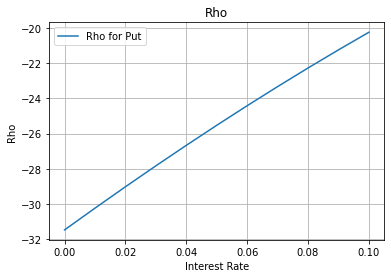

In [121]:
fig = plt.figure()
plt.plot(r, Rho_Put, '-')
plt.grid()
plt.xlabel('Interest Rate')
plt.ylabel('Rho')
plt.title('Rho')
plt.legend(['Rho for Put'])